In [1]:
from glob import glob
import xarray as xr
import pandas as pd
import numpy as np

from scipy.special import gamma
from scipy.integrate import quad

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors

import snowScatt
from pytmatrix import tmatrix, tmatrix_aux, scatter, radar

from __prepare_hydrometeors import get_cloud_dsd, get_rain_dsd
from __prepare_hydrometeors import generate_rain_lookuptable
from __prepare_hydrometeors import get_rime_fraction_index # puts rime fraction into 0(<0 to 0.25) 1(0.25<=x<0.5) 2(0.5<=x<0.75) 3(0.75<x)
from __prepare_hydrometeors import get_rime_density_index # as before but 5 categories, plus it caps rime density
from __prepare_hydrometeors import calc_bulkRhoRime
from __prepare_hydrometeors import calc_threshold # my version vectorizable
from __prepare_hydrometeors import q2abs

import warnings
warnings.simplefilter("ignore")
import time
# Different types of files:
# 2d_cldprcp (ncells, vertices, time), # 2d_cldprcp (ncells, vertices, time) -> 2d fields, strange dimensions
# basic__ (time, lon, lat, height) -> this seems the interesting one
# basic_zlev(time, lon, lat, alt) -> altitude? 93 alts instead of 150 heights???
# hlev_int50m_basic__ (time, lon, lat, height) -> again 93
iconP3path = '/data/optimice/P3paper_ICONoutput/P3realcase__20151124_624m_satad0/hlev_int50m_basic__DOM01_ML_20151124T*Z.nc'
iconP3files = sorted(glob(iconP3path))

# Keep only the important variables
drops = ['u', 'v', 'w',
         #'temp',
         't_g', 'u_10m', 'v_10m',
         'qv', 'clc',
         #'qc', 'qi', 'qr', 'qirim', 'birim', 'qnc', 'qnr', 'qni',
         #'p3eqv_refl', # keeping for comparison purposes
         'p3reff_cld', 'p3reff_ice', 'p3mw_vi', 'p3dmean_ice', 
         #'p3rho_ice', # see if I can make use of it
         'p3ncnuc', 'p3qcnuc', 'p3ncheti', 'p3qcheti', 'p3nrheti', 'p3qrheti', 'p3ninuc', 'p3qinuc',
         'qccondiag', 'qrcondiag', 'dep_rate_ice', 'aggr_ice_n', 't_cbase', 'p_cbase', 't_ctop', 'p_ctop',
         #'rh',
         'temp_old',
         #'pres',
         # 'lamc', 'lamr', 'lami', 'mu_c', 'mu_r' # these Markus calculate himself, why?
        ]
# markusToKeep=["temp","pres","rh","qc","qi","qr","qnc","qni","qnr","qirim","birim"]

# Preprocessing of the data
def generate_preprocess(): # can take arguments
    # Generate a preprocess function that takes a dataset as only argument and does all the processing needed
    def preprocess(ds):
        # Convert strage YMD.fraction_of_the_day format into datetime64 (loss precision not important)
        ds['time'] = pd.to_datetime(ds.time.values.astype(int).astype(str), format='%Y%m%d') + pd.to_timedelta(ds.time.values%1, unit='D').round('1s')
        return ds
    return preprocess
iconP3data = xr.open_mfdataset(iconP3files,
                               concat_dim='time',
                               data_vars='minimal',
                               preprocess=generate_preprocess(), # drop_variables is called first
                               drop_variables=drops
                              ).isel(lat=0, lon=0).squeeze()
datetime = iconP3data.time.values
height = iconP3data.height.values

# To convert from specific to absolute quantities (take out hydrometeor occupied volume from the calculation of air density)
air_density = q2abs(1.0, iconP3data.temp, iconP3data.pres, iconP3data.rh, iconP3data.qc+iconP3data.qr+iconP3data.qi)

In [2]:
#%%timeit
# Compute DSDs parameters my self...
start = time.time()
generate_rain_lookuptable() #generate rain lookup-table at beginning 
mu_r_table = np.load('mu_r_table.npz') #just read the lookup-table
mu_r_table = mu_r_table['mu_r_table']
vector_cloud_dsd = np.vectorize(get_cloud_dsd, otypes=[np.float, np.float])
mu_c, lamc = vector_cloud_dsd(iconP3data.qc, iconP3data.qnc, iconP3data.pres, iconP3data.temp)
vector_rain_dsd = np.vectorize(get_rain_dsd, otypes=[np.float, np.float], excluded=['mu_r_table'])
mu_r, lamr = vector_rain_dsd(iconP3data.qr, iconP3data.qnr, iconP3data.pres, iconP3data.temp, mu_r_table=mu_r_table)
time.time()-start

90.12865257263184

In [3]:
#%%timeit
# Calculate ice properties
start = time.time()
qi_tot = iconP3data.qi + iconP3data.qirim
rime_fraction = iconP3data.qirim/qi_tot.fillna(0.0)
vector_rime_fraction_index = np.vectorize(get_rime_fraction_index)
rime_frac_idx = vector_rime_fraction_index(rime_fraction.fillna(0.0))
vector_bulkRhoRime = np.vectorize(calc_bulkRhoRime)
rime_density = vector_bulkRhoRime(iconP3data.qirim, iconP3data.birim)
vector_rime_density_index = np.vectorize(get_rime_density_index)
rime_density, rime_dens_idx = vector_rime_density_index(rime_density)
vector_ice_PSD = np.vectorize(calc_threshold)
PSD = vector_ice_PSD(rime_dens_idx, rime_frac_idx, iconP3data.qni.fillna(0.0), qi_tot.fillna(0.0), rime_fraction.fillna(0.0), rime_density) # This executes for the whole day in 10 minutes. I guess I can speed up if I find a way to not load the vectors in memory
n_tot, mui, lami, dcrit, dcrits, dcritr, cs1, ds1, cs, ds, cgp, dg, csr, dsr, _, _, _, _, _, _ = PSD
time.time()-start

651.7643303871155

In [80]:
def gammaPSD(N0, mu, lam):
    def N(D):
        return N0*D**mu*np.exp(-lam*D)
    return N

def iceP3mass(dcrit, dcrits, dcritr, cs1, ds1, cs, ds, cgp, dg, csr, dsr):
    functions = [lambda x: np.nan,
                 lambda x: cs1*x**ds1,
                 lambda x: cs*x**ds,
                 lambda x: cgp*x**dg,
                 lambda x: csr*x**dsr]
    def mass(D):
        conditions = [D<=0.0,
                      (0.0<D)*(D<=dcrit),
                      (dcrit<D)*(D<=dcrits),
                      (dcrits<D)*(D<=dcritr),
                      dcritr<D]
        return np.piecewise(D, conditions, functions)
    return mass

def calc_q(N0, mu, lam, dcrit, dcrits, dcritr, cs1, ds1, cs, ds, cgp, dg, csr, dsr, D):
    N = gammaPSD(N0, mu, lam)
    mass = iceP3mass(dcrit, dcrits, dcritr, cs1, ds1, cs, ds, cgp, dg, csr, dsr)
    return (N(D)*mass(D)*np.gradient(D)).sum()
vector_q = np.vectorize(calc_q, excluded=['D'], otypes=[np.float])

def calc_N(N0, mu, lam, D):
    N = gammaPSD(N0, mu, lam)
    return (N(D)*np.gradient(D)).sum()
vector_N = np.vectorize(calc_N, excluded=['D'], otypes=[np.float])

1000000.0 6.71888679596135e-05
0.0010973003055861652 0.0
0.606420707793474 0.0


(array([2.01810e+04, 4.41610e+04, 1.35566e+05, 2.53520e+04, 1.88390e+04,
        1.56900e+03, 7.40000e+01, 2.00000e+01, 4.54700e+03, 2.00000e+00]),
 array([0.     , 0.00011, 0.00022, 0.00033, 0.00044, 0.00055, 0.00066,
        0.00077, 0.00088, 0.00099, 0.0011 ]),
 <a list of 10 Patch objects>)

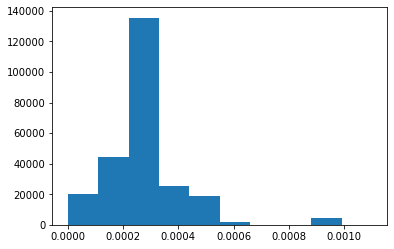

In [143]:
print(np.nanmax(dcrits), np.nanmin(dcrits[np.nonzero(dcrits)]))
print(np.nanmax(dcrits[dcrits<1e3]), np.nanmin(dcrits[dcrits<1e3]))
print(np.nanmax(dcritr[dcritr<1e3]), np.nanmin(dcritr[dcritr<1e3]))
plt.hist(dcritr[(dcritr>0)].flatten(), range=[0, 0.0011])

In [83]:
start = time.time()
# Calculate intercept parameters for all DSDs and PSDs
N0i = n_tot*lami**(mui+1.)/gamma(mui+1.) #*air_density
N0c = iconP3data.qnc*lamc**(mu_c+1.)/gamma(mu_c+1.) #*air_density
N0r = iconP3data.qnr*lamr**(mu_r+1.)/gamma(mu_r+1.) #*air_density

D = np.linspace(1e-5, 0.1, 1000)
qi = vector_q(N0i, mui, lami, dcrit, dcrits, dcritr, cs1, ds1, cs, ds, cgp, dg, csr, dsr, D=D)
Ni = vector_N(N0i, mui, lami, D=D)

ar = 1000.0*np.pi*np.ones_like(mu_r)/6.0
br = 3.0*np.ones_like(mu_r)

D = np.linspace(1e-8, 1e-4, 1000)
qc = vector_q(N0c, mu_c, lamc, 10, 10, 10, ar, br, ar, br, ar, br, ar, br, D=D)
Nc = vector_N(N0c, mu_c, lamc, D=D)

D = np.linspace(1e-6, 0.01, 1000)
qr = vector_q(N0r, mu_r, lamr, 10, 10, 10, ar, br, ar, br, ar, br, ar, br, D=D)
Nr = vector_N(N0r, mu_r, lamr, D=D)
time.time()-start
# 2810 seconds to run???

815.0110065937042

In [160]:
start = time.time()
D = np.linspace(1.0e-6, 0.01, 1000)
func_map = map(iceP3mass, dcrit.flatten(), dcrits.flatten(), dcritr.flatten(), cs1.flatten(), ds1.flatten(), cs.flatten(), ds.flatten(), cgp.flatten(), dg.flatten(), csr.flatten(), dsr.flatten())
func_list = list(fuck)
mass_lists = [f(D) for f in fuck_list]
mass_stack = np.stack(mass_list)
print(time.time()-start)

115.23475456237793


In [1]:
np.stack(fuck_list).shape

NameError: name 'np' is not defined

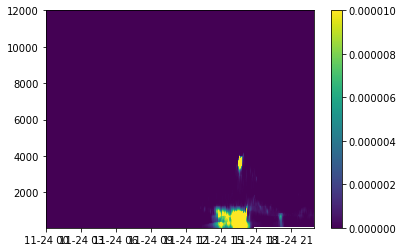

In [156]:
#mesh = plt.pcolormesh(datetime, height, iconP3data.p3rho_ice.T)
#mesh = plt.pcolormesh(datetime, height, rime_dens_idx.T)
#mesh = plt.pcolormesh(datetime, height, rime_frac_idx.T)
#mesh = plt.pcolormesh(datetime, height, qi_tot.T, vmax=0.0003)
#mesh = plt.pcolormesh(datetime, height, iconP3data.qnc.T)
#mesh = plt.pcolormesh(datetime, height, iconP3data.qnr.T)
#mesh = plt.pcolormesh(datetime, height, iconP3data.qni.T, vmax= 350000)
#mesh = plt.pcolormesh(datetime, height, iconP3data.qc.T)
mesh = plt.pcolormesh(datetime, height, iconP3data.qr.T, vmax=0.00001)
#mesh = plt.pcolormesh(datetime, height, iconP3data.qi.T, vmax=0.0002)
#mesh = plt.pcolormesh(datetime, height, rime_density.T)
#mesh = plt.pcolormesh(datetime, height, air_density.T)
#mesh = plt.pcolormesh(datetime, height, iconP3data.rh.T)
plt.colorbar(mesh)

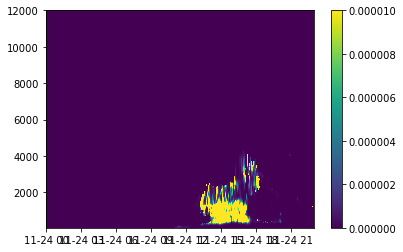

In [17]:
#plt.pcolormesh(datetime, height, iconP3data.temp.T)
#plt.pcolormesh(datetime, height, iconP3data.p3eqv_refl.T)
#mesh = plt.pcolormesh(datetime, height, rime_density.T)
#mesh = plt.pcolormesh(datetime, height, n_tot.T)
#mesh = plt.pcolormesh(datetime, height, qc.T)
mesh = plt.pcolormesh(datetime, height, qr.T, vmax=0.00001)
#mesh = plt.pcolormesh(datetime, height, qi.T, vmax=0.0002)
#mesh = plt.pcolormesh(datetime, height, Ni.T, vmax=350000)
#mesh = plt.pcolormesh(datetime, height, Nc.T)
#mesh = plt.pcolormesh(datetime, height, Nr.T)
plt.colorbar(mesh)

In [20]:
#plt.hist2d(iconP3data.qi, qi)

In [11]:
#mesh = plt.pcolormesh(datetime, height, iconP3data.lamr.T, vmax=30000)
#plt.colorbar(mesh)
#mesh = plt.pcolormesh(datetime, height, lamr.T, vmax=30000)
#plt.colorbar(mesh)
#mesh = plt.pcolormesh(datetime, height, iconP3data.mu_r.T, vmax=2)
#plt.colorbar(mesh)
#mesh = plt.pcolormesh(datetime, height, mu_r.T, vmax=)
#plt.colorbar(mesh)

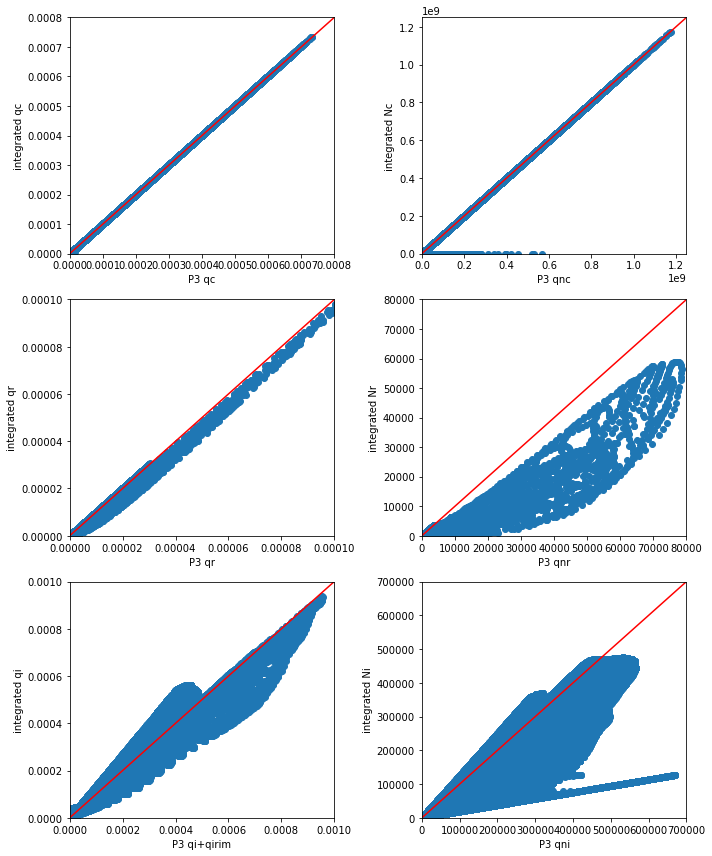

In [108]:
fig, axs = plt.subplots(3, 2, figsize=(10, 12))
axs[0, 0].scatter(iconP3data.qc.values.flatten(), qc.flatten())
qc_lim=[0.0, 0.8e-3]; axs[0, 0].set_xlim(qc_lim); axs[0, 0].set_ylim(qc_lim); axs[0, 0].plot(qc_lim, qc_lim, 'r')
axs[1, 0].scatter(iconP3data.qr.values.flatten(), qr.flatten())
qr_lim=[0.0, 1.0e-4]; axs[1, 0].set_xlim(qr_lim); axs[1, 0].set_ylim(qr_lim); axs[1, 0].plot(qr_lim, qr_lim, 'r')
#axs[2, 0].scatter(iconP3data.qi.values.flatten(), qi.flatten())
axs[2, 0].scatter(qi_tot, qi.flatten())
qi_lim=[0.0, 1e-3]; axs[2, 0].set_xlim(qi_lim); axs[2, 0].set_ylim(qi_lim); axs[2, 0].plot(qi_lim, qi_lim, 'r')

axs[0, 1].scatter(iconP3data.qnc.values.flatten(), Nc.flatten())
Nc_lim=[0.0, 1.25e9]; axs[0, 1].set_xlim(Nc_lim); axs[0, 1].set_ylim(Nc_lim); axs[0, 1].plot(Nc_lim, Nc_lim, 'r')
axs[1, 1].scatter(iconP3data.qnr.values.flatten(), Nr.flatten())
Nr_lim=[0.0, 8.0e4]; axs[1, 1].set_xlim(Nr_lim); axs[1, 1].set_ylim(Nr_lim); axs[1, 1].plot(Nr_lim, Nr_lim, 'r')
axs[2, 1].scatter(iconP3data.qni.values.flatten(), Ni.flatten())
Ni_lim=[0.0, 7.0e5]; axs[2, 1].set_xlim(Ni_lim); axs[2, 1].set_ylim(Ni_lim); axs[2, 1].plot(Ni_lim, Ni_lim, 'r') 
axs[0, 0].set_xlabel('P3 qc'); axs[0, 0].set_ylabel('integrated qc')
axs[1, 0].set_xlabel('P3 qr'); axs[1, 0].set_ylabel('integrated qr')
axs[2, 0].set_xlabel('P3 qi+qirim'); axs[2, 0].set_ylabel('integrated qi')
axs[0, 1].set_xlabel('P3 qnc'); axs[0, 1].set_ylabel('integrated Nc')
axs[1, 1].set_xlabel('P3 qnr'); axs[1, 1].set_ylabel('integrated Nr')
axs[2, 1].set_xlabel('P3 qni'); axs[2, 1].set_ylabel('integrated Ni')
fig.tight_layout()
fig.savefig('scatter_P3_computed.png')

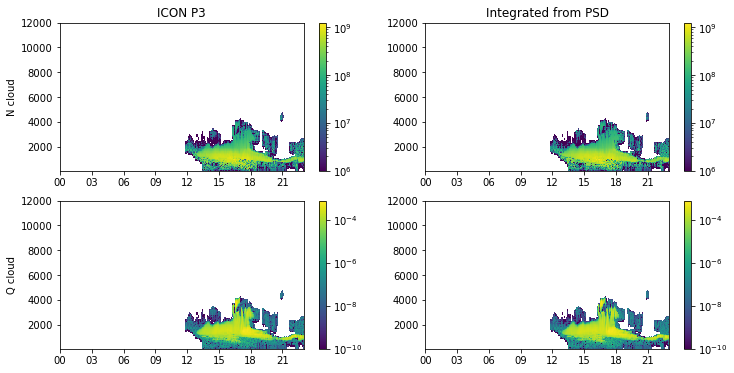

In [110]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6))
mesh = axs[0, 0].pcolormesh(datetime, height, iconP3data.qnc.T, vmax=Nc_lim[1], norm=mcolors.LogNorm(1e6, Nc_lim[1]));
plt.colorbar(mesh, ax=axs[0, 0])
mesh = axs[0, 1].pcolormesh(datetime, height, Nc.T, vmax=Nc_lim[1], norm=mcolors.LogNorm(1e6, Nc_lim[1]));
plt.colorbar(mesh, ax=axs[0, 1])
mesh = axs[1, 0].pcolormesh(datetime, height, iconP3data.qc.T, vmax=qc_lim[1], norm=mcolors.LogNorm(1e-10, qc_lim[1]));
plt.colorbar(mesh, ax=axs[1, 0])
mesh = axs[1, 1].pcolormesh(datetime, height, qc.T, vmax=qc_lim[1], norm=mcolors.LogNorm(1e-10, qc_lim[1]));
plt.colorbar(mesh, ax=axs[1, 1])
axs[0,0].set_title('ICON P3');
axs[0,1].set_title('Integrated from PSD');
axs[0,0].set_ylabel('N cloud'); axs[1,0].set_ylabel('Q cloud');
[a.xaxis.set_major_formatter(mdates.DateFormatter('%H')) for a in axs.flatten()]
fig.savefig('cloud_qN.png')


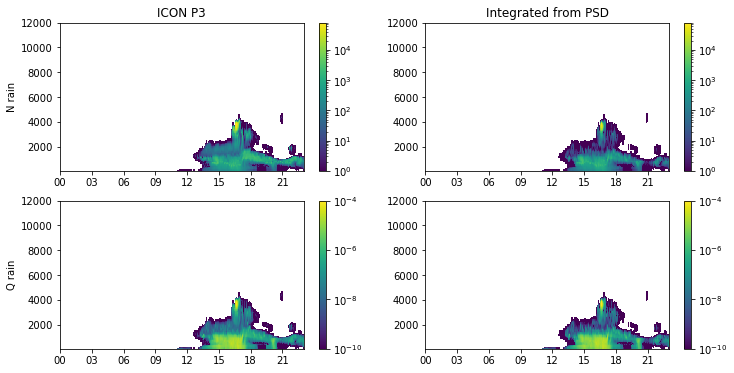

In [98]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6))
mesh = axs[0, 0].pcolormesh(datetime, height, iconP3data.qnr.T, vmax=Nr_lim[1], norm=mcolors.LogNorm(1, Nr_lim[1]));
plt.colorbar(mesh, ax=axs[0, 0])
mesh = axs[0, 1].pcolormesh(datetime, height, Nr.T, vmax=Nr_lim[1], norm=mcolors.LogNorm(1, Nr_lim[1]));
plt.colorbar(mesh, ax=axs[0, 1])
mesh = axs[1, 0].pcolormesh(datetime, height, iconP3data.qr.T, vmax=qr_lim[1], norm=mcolors.LogNorm(1e-10, qr_lim[1]));
plt.colorbar(mesh, ax=axs[1, 0])
mesh = axs[1, 1].pcolormesh(datetime, height, qr.T, vmax=qr_lim[1], norm=mcolors.LogNorm(1e-10, qr_lim[1]));
plt.colorbar(mesh, ax=axs[1, 1])
axs[0,0].set_title('ICON P3');
axs[0,1].set_title('Integrated from PSD');
axs[0,0].set_ylabel('N rain');
axs[1,0].set_ylabel('Q rain');
[a.xaxis.set_major_formatter(mdates.DateFormatter('%H')) for a in axs.flatten()]
fig.savefig('rain_qN.png')



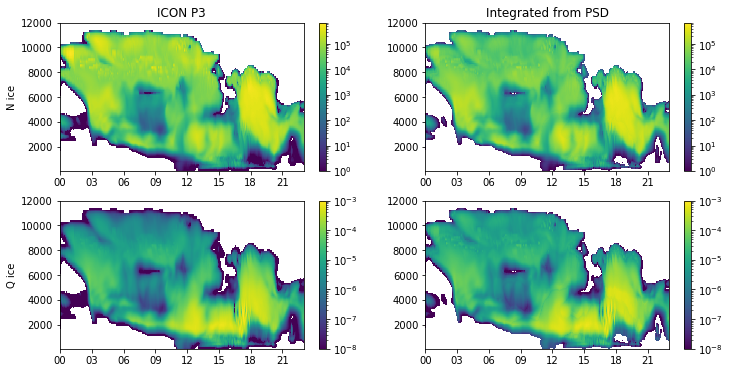

In [100]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6))
mesh = axs[0, 0].pcolormesh(datetime, height, iconP3data.qni.T, vmax=Ni_lim[1], norm=mcolors.LogNorm(1, Ni_lim[1]))
plt.colorbar(mesh, ax=axs[0, 0])
mesh = axs[0, 1].pcolormesh(datetime, height, Ni.T, vmax=Ni_lim[1], norm=mcolors.LogNorm(1, Ni_lim[1]));
plt.colorbar(mesh, ax=axs[0, 1])
mesh = axs[1, 0].pcolormesh(datetime, height, iconP3data.qi.T+iconP3data.qirim.T, vmax=qi_lim[1], norm=mcolors.LogNorm(1e-8, qi_lim[1]));
plt.colorbar(mesh, ax=axs[1, 0])
mesh = axs[1, 1].pcolormesh(datetime, height, qi.T, vmax=qi_lim[1], norm=mcolors.LogNorm(1e-8, qi_lim[1]));
plt.colorbar(mesh, ax=axs[1, 1])
axs[0,0].set_title('ICON P3');
axs[0,1].set_title('Integrated from PSD');
axs[0,0].set_ylabel('N ice');
axs[1,0].set_ylabel('Q ice');
[a.xaxis.set_major_formatter(mdates.DateFormatter('%H')) for a in axs.flatten()]
fig.savefig('ice_qN.png')

In [107]:
np.nanmin(iconP3data.qnc)

0.0